## Processing product-client-depot
The goal is to use the existing PCD dataset obtained by grouping the df_train and predict the demand for a given pcd tuple for the unknown ones.

In [12]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv('processed/by_pcd.csv',nrows=200000)

In [5]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,\
                     train_scores_mean + train_scores_std, alpha=0.1,\
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,\
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",\
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",\
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.5/site-packages/matplotlib/pyplot.py'>

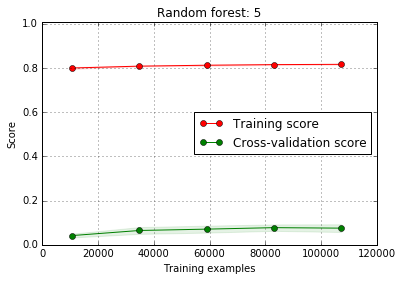

In [14]:
X = df[['ProductId','ClientId','DepotId']]
y = np.log1p(df.AdjDemand)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Fit the model
n_est = 5
model = RandomForestRegressor(n_estimators = n_est)
title = 'Random forest: ' + str(n_est)
model.fit(X_train,y_train)

# plot the learning curve
plot_learning_curve(model, title, X_train, y_train, ylim=(0.0, 1.01), cv=5, n_jobs=4)

Feature ranking:
1. ClientId (0.574230)
2. ProductId (0.246221)
3. DepotId (0.179549)


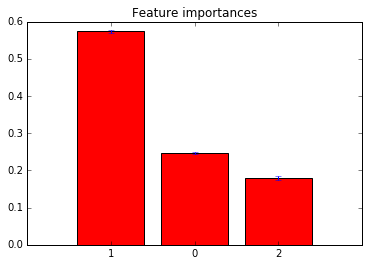

Pred:     0.2601, Mean:    16.7965


In [28]:
# Plot feature importance
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# Evaluate quality of prediction on test dataset
y_pred_s = model.predict(X_test)
mse_pred = mean_squared_error(y_pred_s,y_test)

product_mean = df.groupby('ProductId').agg({'AdjDemand':np.mean})
y_mean_predict = pd.merge(X_test,product_mean.reset_index(),on=['ProductId'],how='left')
y_mean_predict = y_mean_predict.AdjDemand
mse_mean = mean_squared_error(y_mean_predict,y_test)


print ("Pred: {:10.4f}, Mean: {:10.4f}".format(mse_pred,mse_mean))

In [25]:
y_mean_predict = pd.merge(X_test,product_mean.reset_index(),on=['ProductId'],how='left')
y_mean_predict = y_mean_predict.AdjDemand